# Bayesian neural network
In this notebook, we make use of HMC to estimate the posterior predictive distribution over the rotating MNIST dataset with missing rotations, which we call _trenches_.

In [1]:
import jax
import blackjax
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from typing import Callable
from dynamax.utils import datasets
from jaxtyping import Float, Array
from dataclasses import dataclass
from jax.flatten_util import ravel_pytree

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [2]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)
key_warmup, key_train = jax.random.split(key_train)

In [3]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

In [12]:
@dataclass
class PriorParam:
    scale_obs: float
    scale_weight: float


def get_leaves(params):
    flat_params, _ = ravel_pytree(params)
    return flat_params


def log_joint(
    params: nn.FrozenDict,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam,
):
    """
    TODO:
    * Add more general way to compute observation-model log-probability
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    params_flat = get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()
    
    logprob = logp_prior + logp_obs
    return logprob


def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


# Rotating MNIST

In [4]:
np.random.seed(314)
train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

num_train, dim_input = X_train.shape

In [5]:
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, dim_hidden=200, activation=nn.elu)
batch = jnp.ones(batch)

In [6]:
params_init = model.init(key_init, batch)
_, reconstruct_fn = ravel_pytree(params_init)

In [23]:
%%time
num_eval = 2000
num_warmup = 200
num_steps = 100

X_eval = X_train[:num_eval]
y_eval = y_train[:num_eval]
# Sample initial parameters
priors = PriorParam(scale_obs=2.0, scale_weight=1/2)
potential = partial(log_joint,
                    priors=priors, X=X_eval, y=y_eval,
                    reconstruct_fn=reconstruct_fn, model=model)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params_init)
states = inference_loop(key_train, kernel, final_state, num_steps)

sampled_params = jax.block_until_ready(states.position)

CPU times: user 24.4 s, sys: 743 ms, total: 25.2 s
Wall time: 1min 52s


## Evaluation metrics

In [28]:
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_test).squeeze()
yhat_train_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_train).squeeze()

### Mean absolute error

In [29]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(7.923488, dtype=float32)

In [30]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(14.140289, dtype=float32)

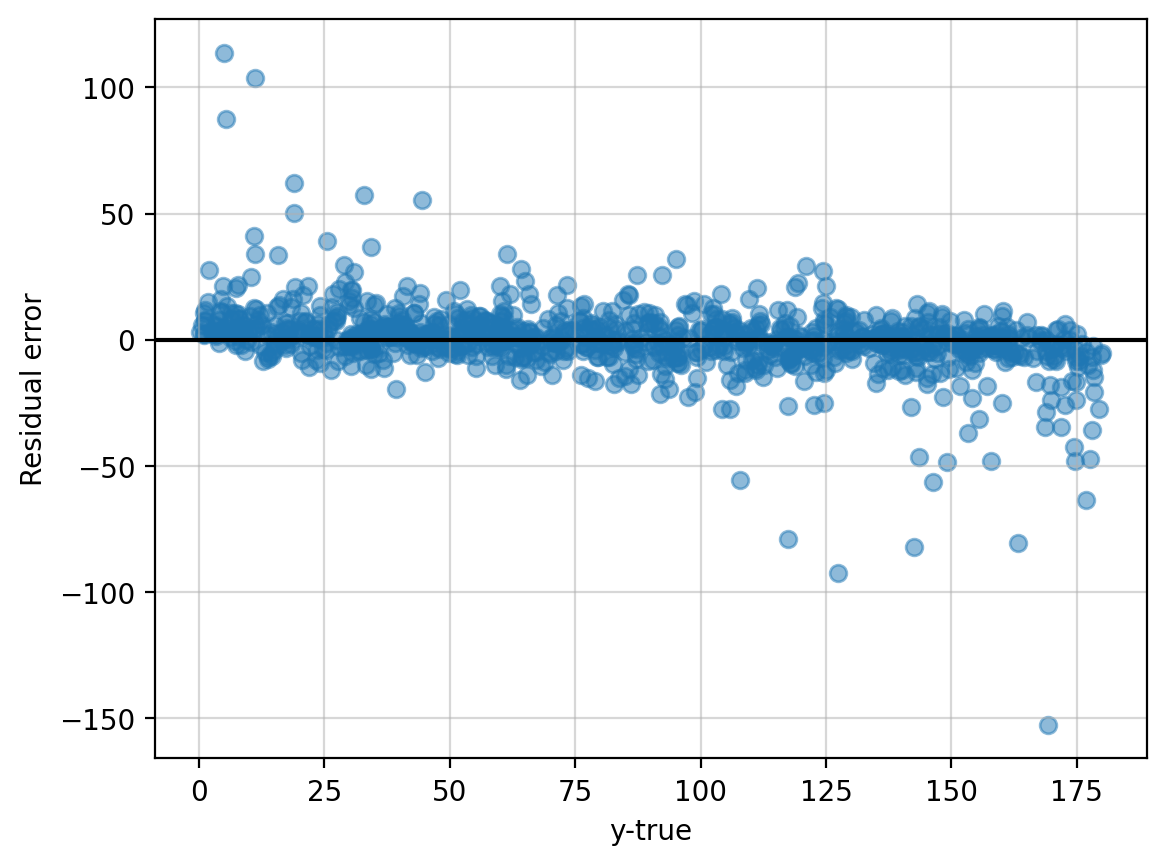

In [31]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

### Negative marginal log-likelihood

The marginal log-likelihood can be approximated as
$$
\begin{aligned}
    \log p(y \vert x, \cal D)
    &= \log\int p({\bf w} \vert \cal D) p(y \vert x, {\bf w}) d{\bf w}\\
    &= \log \mathbb{E}_{p({\bf w}\vert \cal D)}[p(y \vert x, {\bf w})] \\
    &\leq \mathbb{E}_{p({\bf w}\vert \cal D)}[\log p(y \vert x, {\bf w})] \\
    &\approx \frac{1}{S}\sum_{s=1}^S\log p\left(y \vert x, {\bf w}^{(s)}\right); {\bf w}^{(s)} \sim p(\cdot \vert \cal D)
\end{aligned} 
$$

In [32]:
means = yhat_samples.mean(axis=0).sum()
nll = -distrax.Normal(means, priors.scale_obs).log_prob(y_test).mean()
nll

Array(1.0203603e+09, dtype=float32)

## The trenches

1. $[0, 45] \cup [90, 135]$

In [48]:
map_trench_1 = (y_train  >= 0) & (y_train <= 45)
map_trench_2 = (y_train >= 90) & (y_train <= 135)
map_trench = map_trench_1 | map_trench_2

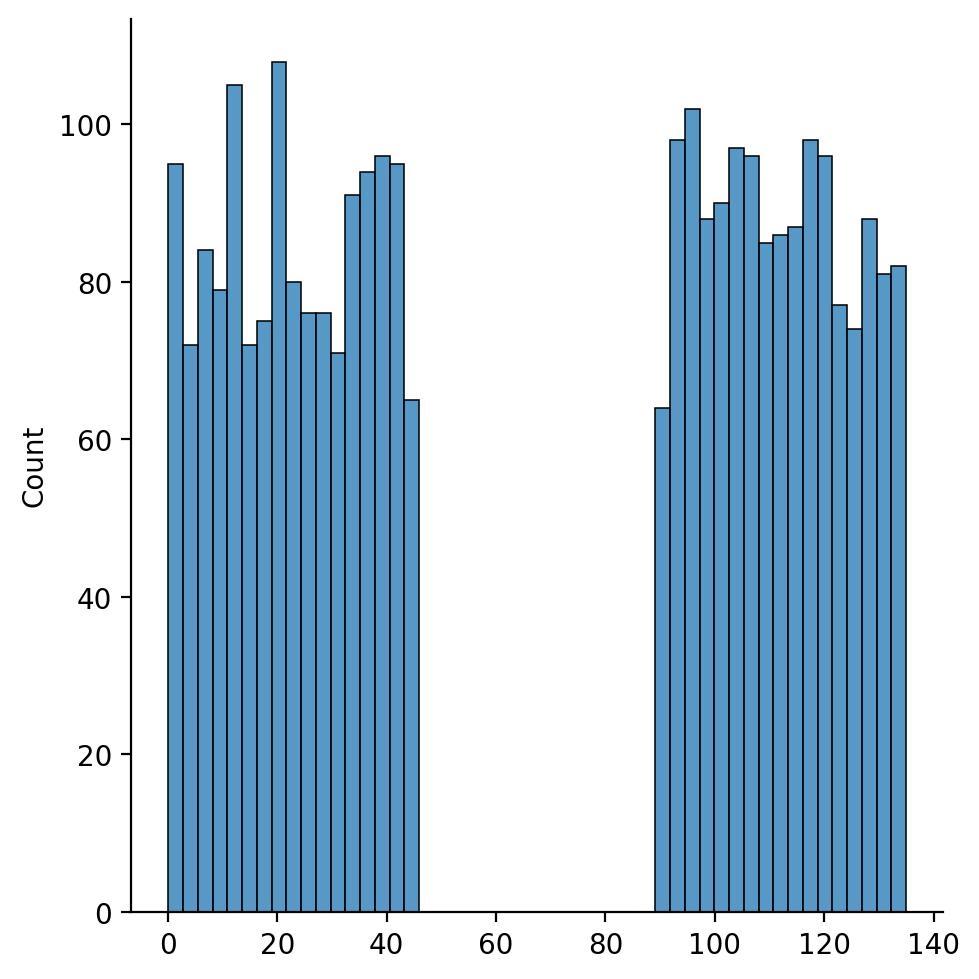

In [64]:
y_eval = y_train[map_trench]
X_eval = X_train[map_trench]
sns.displot(y_eval, bins=50)

In [55]:
%%time
num_warmup = 200
num_steps = 100

# Sample initial parameters
priors = PriorParam(scale_obs=2.0, scale_weight=1/2)
potential = partial(log_joint,
                    priors=priors, X=X_eval, y=y_eval,
                    reconstruct_fn=reconstruct_fn, model=model)

adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params_init)
states = inference_loop(key_train, kernel, final_state, num_steps)

sampled_params = jax.block_until_ready(states.position)

CPU times: user 26.1 s, sys: 1.11 s, total: 27.2 s
Wall time: 2min 27s


## Evaluation metrics

In [251]:
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_test).squeeze()
yhat_train_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_train).squeeze()

### Mean absolute error

In [252]:
yhat_test = yhat_samples.mean(axis=0)
metric_mae = jnp.abs(yhat_test - y_test).mean()
metric_mae

Array(18.058844, dtype=float32)

In [253]:
metric_rmse = jnp.sqrt(jnp.power(yhat_test - y_test, 2).mean())
metric_rmse

Array(32.55276, dtype=float32)

In [254]:
xtrench1 = jnp.linspace(45, 90, 100)
xtrench2 = jnp.linspace(135, 180, 100)

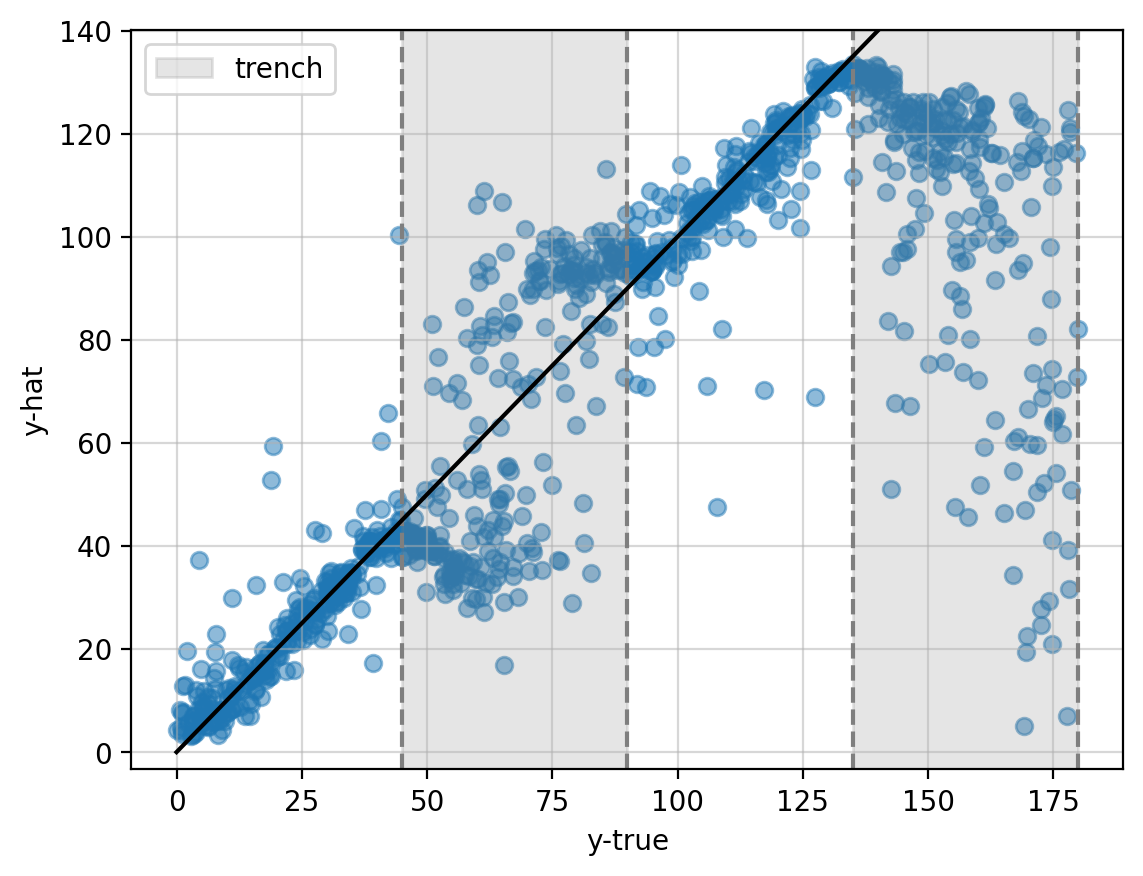

In [255]:
residual_err = yhat_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

In [329]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

# group_ix = jnp.digitize(yhat_test, rotations)
group_ix = jnp.digitize(y_test, rotations)

summary_est = pd.DataFrame({
    "y_hat": np.array(yhat_test),
    "group": np.array(group_ix),
}).groupby("group").mean()


summary_est_std = pd.DataFrame({
    "y_hat_std": np.array(yhat_test),
    "group": np.array(group_ix),
}).groupby("group").std()


summary_true = pd.DataFrame({
    "y_true": np.array(y_test),
    "group": np.array(group_ix),
}).groupby("group").mean()

summary = summary_true.join(summary_est).join(summary_est_std)

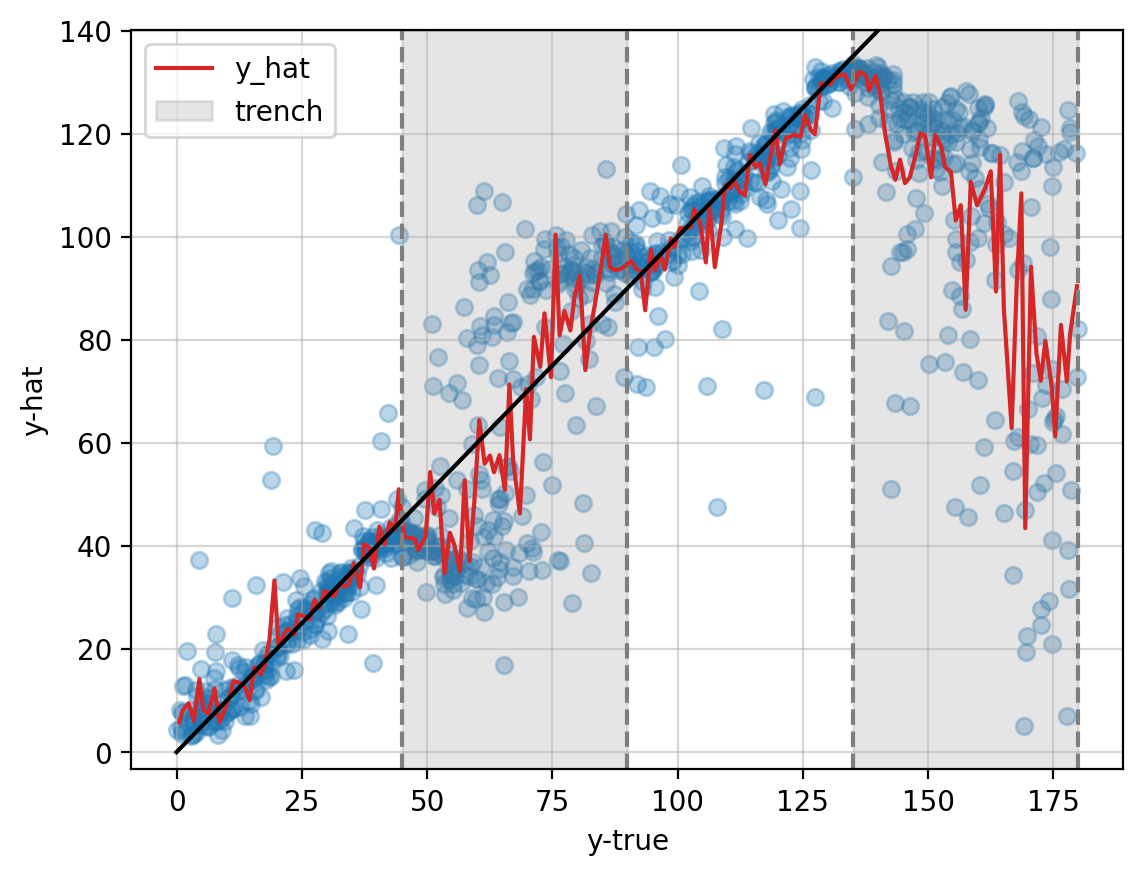

In [339]:
residual_err = yhat_test
fig, ax = plt.subplots()

summary.plot(x="y_true", y="y_hat", ax=ax, c="tab:red")

plt.scatter(y_test, residual_err, alpha=0.3, edgecolors=None)
plt.ylabel("y-hat")
plt.xlabel("y-true")

# Trenches
ymin, ymax = plt.ylim()

plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

# plt.axhline(y=0, c="black")
plt.plot([0, 180], [0, 180], c="black")

plt.ylim(ymin, ymax)
plt.legend()
plt.grid(alpha=0.5)

### Evaluating the posterior predictive as a function of rotation angle

In [129]:
x_target = np.array(X_eval[0]).reshape(28, 28)
y_init = float(y_eval[0].item())
x_target = datasets.rotate_mnist(x_target, -y_init).ravel()

We consider the same image rotated from 0 to 180 degrees

In [140]:
n_rotations = 181
rotations = np.linspace(0, 180, n_rotations)

In [152]:
def generate_rotated_images(images, angles, n_processes=1):
    n_configs = len(images)
    processer = datasets.DataAugmentationFactory(datasets.rotate_mnist)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = processer(images, configs, n_processes=n_processes)
    return images_proc, angles

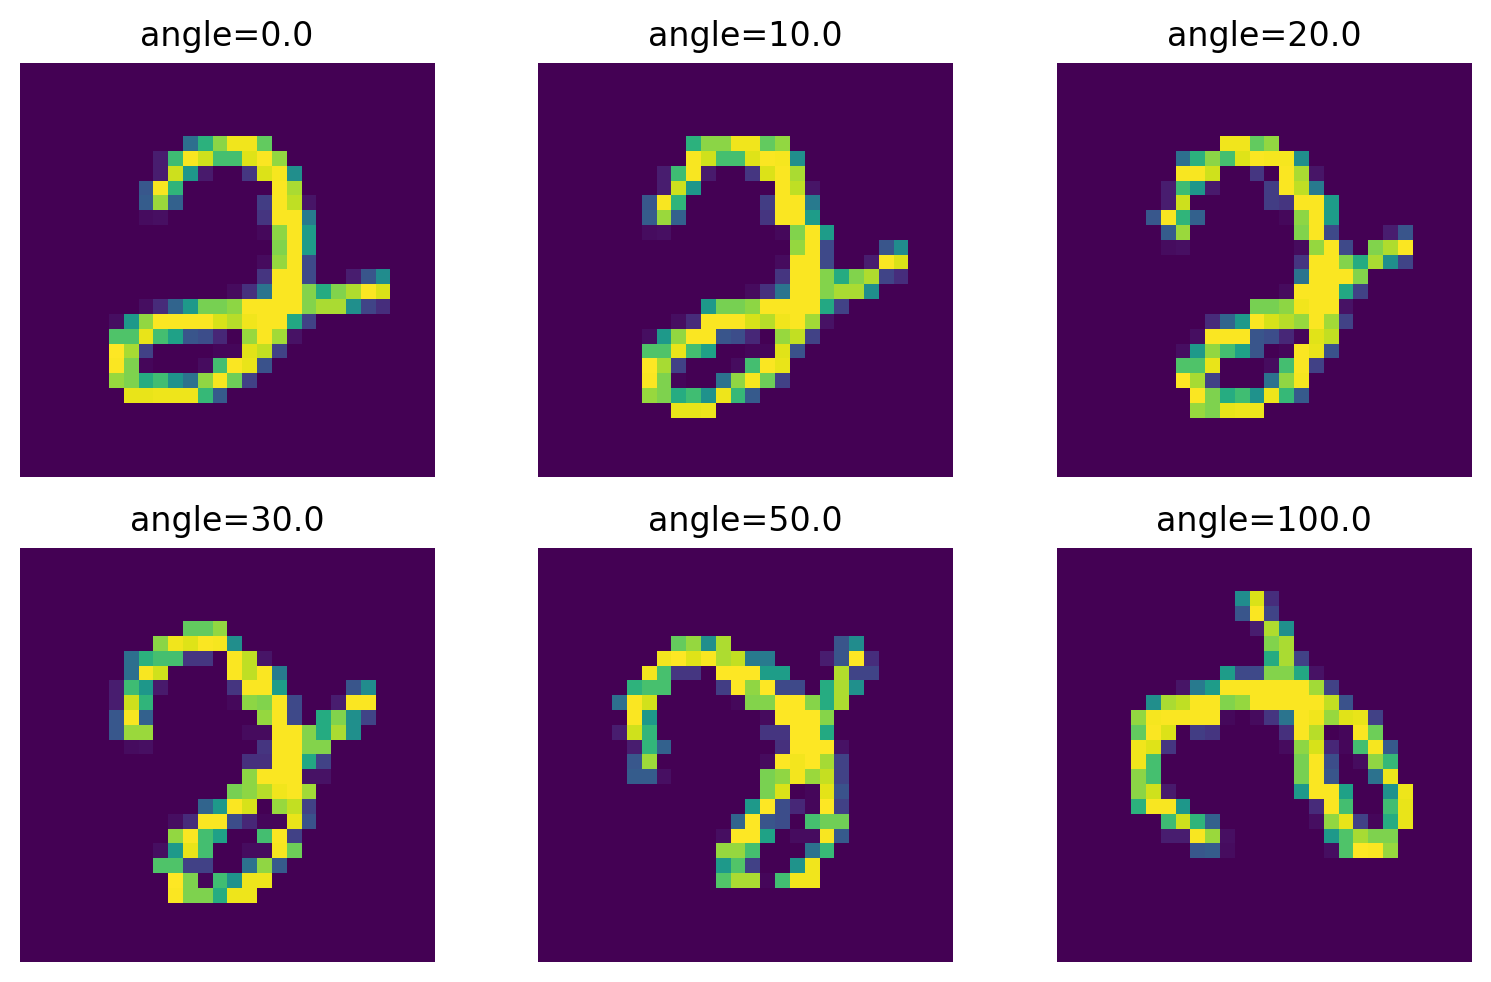

In [187]:
X_target = x_target[None, :] * jnp.ones(n_rotations)[..., None]
X_target = np.array(X_target.reshape(-1, 28, 28))
X_target, y_target = generate_rotated_images(X_target, rotations)

X_target = X_target.reshape(-1, 28 ** 2)

ixs = [0, 10, 20, 30, 50, 100, 180]

fig, axs = plt.subplots(2, 3, figsize=(8, 5))
axs = axs.ravel()
for ax, ix in zip(axs, ixs):
    ax.imshow(X_target[ix].reshape(28, 28))
    ax.axis("off")
    angle = y_target[ix]
    ax.set_title(f"{angle=}")
plt.tight_layout()

# To TPU
X_target = jnp.array(X_target)
y_target = jnp.array(y_target)

In [202]:
%%time
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, X_target).squeeze()

CPU times: user 3.79 s, sys: 10.4 ms, total: 3.8 s
Wall time: 2.87 s


In [218]:
yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

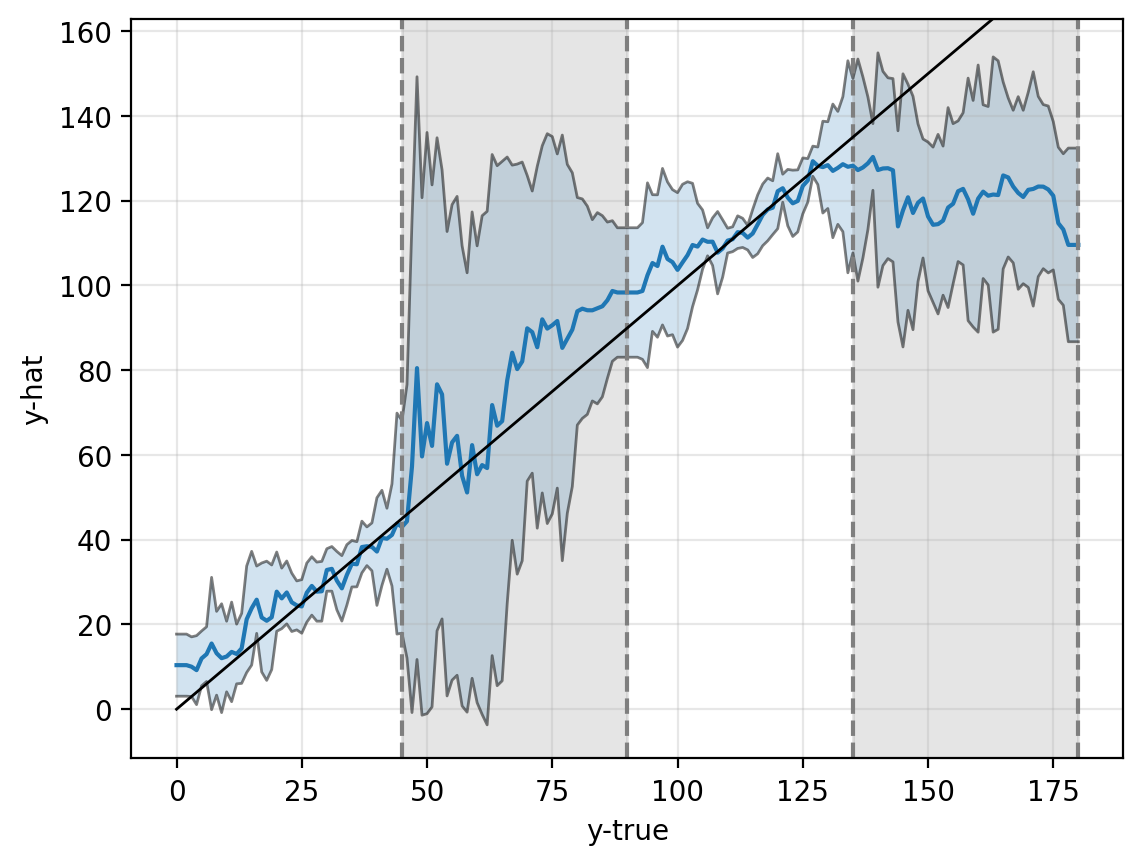

In [322]:
plt.plot(y_target, yhat_mean)

lbound = yhat_mean - 1.96 * yhat_std
ubound = yhat_mean + 1.96 * yhat_std
plt.fill_between(y_target, lbound, ubound, alpha=0.2)
plt.plot(y_target, lbound, c="black", linewidth=1, alpha=0.5)
plt.plot(y_target, ubound, c="black", linewidth=1, alpha=0.5)

plt.xlabel("y-true")
plt.ylabel("y-hat")

ymin, ymax  = plt.ylim()


plt.axvline(x=45, c="tab:gray", linestyle="--")
plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.fill_between(xtrench1, ymax, ymin, alpha=0.2, color="tab:gray", label="trench")

plt.axvline(x=135, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.fill_between(xtrench2, ymax, ymin, alpha=0.2, color="tab:gray")

plt.plot([0, 180], [0, 180], c="black", linewidth=1)
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)